In [ ]:
# ! pip uninstall surface_erasure_decoding
# ! pip3 install git+https://github.com/JiakaiW/surface_erasure_decoding

In [7]:
from surface_erasure_decoding import sur_job
import uuid
import itertools
import pickle
import zipfile
import os
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import json
import datetime
import numpy as np

unsaturated_colors = {
    'red': {
        3: (0.86, 0.371, 0.339),
        5: (0.8, 0.251, 0.231),
        7: (0.71, 0.086, 0.063),
        9: (0.64, 0.051, 0.051),
        11: (0.53, 0.035, 0.035),
        13: (0.43, 0.024, 0.024)
    },
    'blue': {
        3: (0.353, 0.678, 0.901),
        5: (0.255, 0.502, 0.701),
        7: (0.157, 0.322, 0.502),
        9: (0.086, 0.231, 0.365),
        11: (0.063, 0.184, 0.325),
        13: (0.039, 0.137, 0.286)
    },
    'green': {
        3: (0.467, 0.775, 0.459),
        5: (0.376, 0.686, 0.373),
        7: (0.286, 0.596, 0.286),
        9: (0.216, 0.51, 0.216),
        11: (0.169, 0.435, 0.169),
        13: (0.133, 0.365, 0.133)
    },
    'light_purple': {
        3: (0.659, 0.486, 0.756),
        5: (0.557, 0.376, 0.647),
        7: (0.467, 0.278, 0.549),
        9: (0.388, 0.192, 0.459),
        11: (0.318, 0.118, 0.384),
        13: (0.259, 0.059, 0.318)
    }
}


In [8]:
# d_to_shots = {3: int(1e5), # 5,000s, 83min
#               5:int(2e4), # 10,500s, 175 min
#               7:int(1e4), # 5,500 s, 91 min
#               9: int(1e4), # 11,000 s, 180 min
#               11: int(1e4) # 20700 s, 360 min
#               }# =>900 min per parameter set

distance_to_sec_per_shot = {
    3:0.1,
    5:0.2,
    7:0.5,
    9:1,
    11:2
}

qbt_lifetime_array: ['1.00e-02', '1.51e-02', '2.28e-02', '3.43e-02', '5.18e-02', '7.81e-02', '1.18e-01', '1.78e-01', '2.68e-01', '4.05e-01', '6.11e-01', '9.21e-01', '1.39e+00', '2.10e+00', '3.16e+00']
p_p_array: [2.00000000e-02 1.32574063e-02 8.78794112e-03 5.82526531e-03
 3.86139546e-03 2.55960443e-03 1.69668580e-03 1.12468265e-03
 7.45518744e-04 4.94182246e-04 3.27578741e-04 2.17142224e-04
 1.43937135e-04 9.54116539e-05 6.32455532e-05]
decay_lifetime_array: ['2.00e-03', '2.84e-03', '4.05e-03', '5.77e-03', '8.23e-03', '1.17e-02', '1.67e-02', '2.38e-02', '3.39e-02', '4.84e-02', '6.89e-02', '9.82e-02', '1.40e-01', '2.00e-01']
p_e_array: [0.10023745 0.070337   0.04935574 0.03463311 0.02430219 0.01705294
 0.01196611 0.00839667 0.00589197 0.00413442 0.00290114 0.00203574
 0.00142849 0.00100237]
num combinations 210, num jobs (for all distances) per combination with 1e4 jobs tot cap: 47


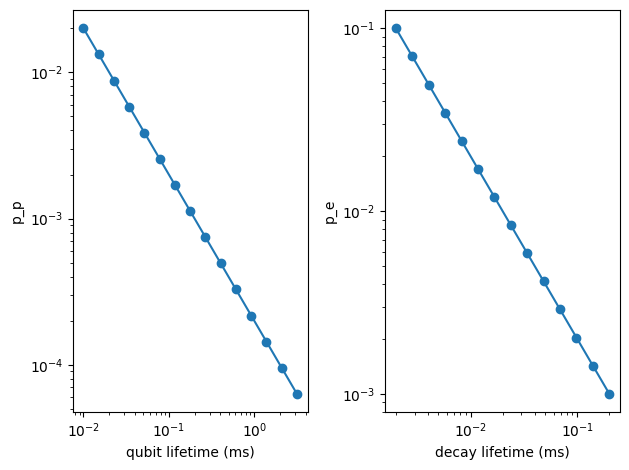

In [103]:
gate_time = 200*1e-6 # ms
qbt_lifetime_array = 10 ** np.linspace(-2,0.5,15) # ms
formatted_floats = [f"{num:.2e}" for num in qbt_lifetime_array]
print(f"qbt_lifetime_array: {formatted_floats}")

p_p_array = gate_time / qbt_lifetime_array
print(f"p_p_array: {p_p_array}")

fig, axes = plt.subplots(1,2)
axes[0].plot(qbt_lifetime_array,p_p_array,marker = 'o')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('qubit lifetime (ms)')
axes[0].set_ylabel('p_p')


decay_lifetime_array = 10 ** np.linspace(-2.7,-0.7,14)# ms
formatted_floats = [f"{num:.2e}" for num in decay_lifetime_array]
print(f"decay_lifetime_array: {formatted_floats}")

p_e_array = gate_time / decay_lifetime_array
print(f"p_e_array: {p_e_array}")

axes[1].plot(decay_lifetime_array,p_e_array,marker = 'o')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('decay lifetime (ms)')
axes[1].set_ylabel('p_e')


plt.tight_layout()

p_e_list = list(p_e_array)
p_z_shift_list = [0.0]
p_m_list = [0.0]
p_p_list = list(p_p_array)

combinations = list(itertools.product(p_e_list, 
                                      p_z_shift_list,
                                      p_m_list,
                                      p_p_list))
print(f"num combinations {len(combinations)}, num jobs (for all distances) per combination with 1e4 jobs tot cap: {int(1e4/len(combinations))}")


In [104]:
p_p_list

[0.019999999999999997,
 0.013257406323652889,
 0.00878794112152158,
 0.005825265309817476,
 0.003861395457766499,
 0.0025596044279959074,
 0.0016966857964881442,
 0.001124682650380698,
 0.0007455187440629879,
 0.0004941822455971208,
 0.00032757874139081276,
 0.00021714222388044075,
 0.00014393713460023042,
 9.541165392287853e-05,
 6.324555320336758e-05]

In [105]:
p_e_list

[0.10023744672545448,
 0.07033700014339496,
 0.049355742297809514,
 0.03463311333724167,
 0.02430218822751778,
 0.017052938524317534,
 0.01196611225259428,
 0.008396666781944982,
 0.005891973228960217,
 0.004134420173184783,
 0.0029011384648558285,
 0.0020357399682922515,
 0.0014284865299279965,
 0.0010023744672545444]

In [109]:
shots_per_d9_job  = 8000
d_to_num_shots_per_job = {
    9: shots_per_d9_job,
    7: shots_per_d9_job * 2 ,
    5: shots_per_d9_job * 4,
    3: shots_per_d9_job * 8,
}

print(f"time per job: {shots_per_d9_job * distance_to_sec_per_shot[9]} sec, in minutes: {shots_per_d9_job * distance_to_sec_per_shot[9] / 60}")

d_to_num_jobs = {
    9: 33,
    7: 10,
    5: 3,
    3: 1
}

print(f"d3 tot shots {d_to_num_shots_per_job[3] * d_to_num_jobs[3]}")
print(f"d5 tot shots {d_to_num_shots_per_job[5] * d_to_num_jobs[5]}")
print(f"d7 tot shots {d_to_num_shots_per_job[7] * d_to_num_jobs[7]}")
print(f"d9 tot shots {d_to_num_shots_per_job[9] * d_to_num_jobs[9]}")


time per job: 8000 sec, in minutes: 133.33333333333334
d3 tot shots 64000
d5 tot shots 96000
d7 tot shots 160000
d9 tot shots 264000


In [110]:
counter = 0
jobs_info = []

for (p_e,p_z_shift,p_m,p_p) in combinations:
    for d in [3,5,7,9]:
        num_jobs = d_to_num_jobs[d]
        num_shots_per_job = d_to_num_shots_per_job[d]
        
        circuit_id=str(uuid.uuid4())
        for _ in range(num_jobs):
            job_id=str(uuid.uuid4())
            job = sur_job.Sample_decode_job(
                            job_id=job_id,
                            circuit_id=circuit_id,
                            d = d,
                            p_e=p_e,
                            p_z_shift= p_z_shift,
                            p_p=p_p,
                            p_m = p_m,
                            shots=num_shots_per_job,
                            )
            with open(f"{counter}.pkl", "wb") as f:
                pickle.dump(job, f)
            counter += 1

            jobs_info.append({
                "job_id": job_id,
                "circuit_id": circuit_id,
                "d": d,
                "p_e": p_e,
                "p_z_shift": p_z_shift,
                "p_p": p_p,
                "p_m": p_m,
                "shots": num_shots_per_job,
                "file": f"{counter}.pkl"
            })
print(f"num_jobs: {counter}")

# Save jobs information to a JSON file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"jobs_info_{timestamp}.json"
with open(json_filename, "w") as json_file:
    json.dump(jobs_info, json_file, indent=4)

def pack_pkl_files_to_zip(zip_filename="erasure_input.zip"):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for filename in os.listdir('.'):
            name, ext = os.path.splitext(filename)
            if ext == '.pkl' and name.isdigit():
                zipf.write(filename)
                os.remove(filename)
                
pack_pkl_files_to_zip()

num_jobs: 9870


In [111]:
len(jobs_info)

9870

In [11]:
import os
import json
import pandas as pd

json_list = []
directory = "erasure_decode_result"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

# directory = "erasure_decode_result 2"
# for filename in os.listdir(directory):
#     if filename.endswith(".txt"):
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'r') as f:
#             json_data = json.load(f)
#         json_list.append(json_data)

df = pd.DataFrame(json_list)


In [13]:
pd.set_option('display.max_rows', 10)

df.head(10)

,job_id,circuit_id,d,p_e,p_z_shift,p_p,p_m,shots,new_circ
0,6cee8fa1-a6fb-4c46-a591-12825f0d1ad4,0168de08-7b57-4f96-9d6a-cde9041f3d91,3,0.04,0.0,0.001,0.000,16000,97
1,32da4fba-fade-4cb8-a7ad-f90a9a38690a,af8a51ff-300c-42cd-abe7-6dce37072720,3,0.05,0.0,0.006,0.000,16000,596
2,0b8ff09e-b3ce-4fb5-95e1-a962b9b7027d,266edf13-94eb-47c6-a02d-ceaca9e1cca5,9,0.08,0.0,0.006,0.001,2000,385
3,55d0cc8d-eafb-4e01-96ae-406eec4e5e7f,bb1c26b5-5675-42cc-84c1-b86048738d2d,9,0.01,0.0,0.010,0.001,2000,84
4,ea85d1fb-0ad8-40e7-9cee-d64f248b0e89,e28ef0cf-500e-4b37-aba4-b52e6c5785a8,9,0.07,0.0,0.002,0.000,2000,56
5,6c16385d-ebc0-4275-977c-f8d3279aa3a0,72cf1493-3930-4545-8dfd-c1eb437ea659,9,0.08,0.0,0.001,0.000,2000,40
6,addada7f-1d99-443a-918f-456a18548832,ab87ca0d-a715-44cc-846d-2558b21df641,9,0.06,0.0,0.010,0.001,2000,441
7,928e4df7-25f5-47a4-aa0c-7b5574b287a4,09fedd31-0d72-4f9e-9d14-a0062ce92905,7,0.07,0.0,0.002,0.001,4000,103
8,669fd280-a147-4ba7-8067-9b7a6badf50f,85092b88-feb1-480f-88bd-539189f58e41,9,0.02,0.0,0.006,0.000,2000,11
9,e02ef330-2ddf-4456-828c-6d8c0b40ce7c,84a7879a-e89e-48ed-8533-a830f56c88dd,9,0.05,0.0,0.010,0.000,2000,351


In [32]:
# df.drop('job_id', axis=1, inplace=True)
agg_rules = {
    'shots': 'sum',
    'new_circ': 'sum',
    # 'normal': 'sum',
    'p_e': 'first',
    'p_z_shift': 'first',
    'p_p': 'first',
    'p_m': 'first',
}

df_grouped = df.groupby(['circuit_id', 'd']).agg(agg_rules).reset_index()
df_grouped['p_logi_era'] = df_grouped['new_circ'] / df_grouped['shots']
# df_grouped['p_logi_normal'] = df_grouped['normal'] / df_grouped['shots']

pd.set_option('display.max_rows', 15)
df_grouped.head(15)

,circuit_id,d,shots,new_circ,p_e,p_z_shift,p_p,p_m,p_logi_era
0,0135d3f5-f822-4cda-80cb-57a9c71543b4,7,80000,6963,0.05,0.0,0.008,0.000,0.087038
1,01667e00-260b-4d13-9c10-a8dec345b476,7,80000,40,0.02,0.0,0.002,0.000,0.000500
2,0168de08-7b57-4f96-9d6a-cde9041f3d91,3,32000,188,0.04,0.0,0.001,0.000,0.005875
3,01941919-9f9a-4a7e-a063-6d4fa645ed3c,7,80000,627,0.03,0.0,0.004,0.001,0.007838
4,01f1ee67-d92c-49ff-8e01-e11d8a735a7e,7,80000,5957,0.06,0.0,0.006,0.001,0.074463
5,04c52334-7d8d-43b6-915d-85dd8fb7cc01,9,148000,51640,0.08,0.0,0.010,0.001,0.348919
6,0519e499-2540-427e-9106-524481ba7bf5,9,148000,657,0.05,0.0,0.002,0.001,0.004439
7,052b7f6a-f7f3-4034-84d0-e23727caa144,5,48000,4783,0.08,0.0,0.006,0.000,0.099646
8,056eac90-bd1a-4b6f-a6f4-43a2c45d62b1,7,80000,406,0.06,0.0,0.001,0.000,0.005075
9,058226f6-6b1a-45cc-a5c6-8655c2cd912b,5,48000,959,0.01,0.0,0.008,0.001,0.019979


In [31]:
# After grouping there should be 96 * 4 = 384 rows.
df_grouped

,circuit_id,d,shots,new_circ,p_e,p_z_shift,p_p,p_m,p_logi_era
0,0135d3f5-f822-4cda-80cb-57a9c71543b4,7,80000,6963,0.05,0.0,0.008,0.000,0.087038
1,01667e00-260b-4d13-9c10-a8dec345b476,7,80000,40,0.02,0.0,0.002,0.000,0.000500
2,0168de08-7b57-4f96-9d6a-cde9041f3d91,3,32000,188,0.04,0.0,0.001,0.000,0.005875
3,01941919-9f9a-4a7e-a063-6d4fa645ed3c,7,80000,627,0.03,0.0,0.004,0.001,0.007838
4,01f1ee67-d92c-49ff-8e01-e11d8a735a7e,7,80000,5957,0.06,0.0,0.006,0.001,0.074463
...,...,...,...,...,...,...,...,...,...
379,fa5813e5-db9f-43eb-930c-554a6b90ffb9,3,32000,906,0.04,0.0,0.006,0.000,0.028313
380,fbd69e6a-43fb-4d33-86ef-813100651d5a,3,32000,770,0.02,0.0,0.008,0.000,0.024063
381,fcad2946-59bb-4b8d-ba65-8579794a2e54,9,148000,332,0.02,0.0,0.004,0.001,0.002243
382,fe13c9be-7766-44b5-96a8-b8b3ab763bf4,9,148000,34318,0.06,0.0,0.010,0.000,0.231878


In [15]:
def compute_binary_confidence_interval(num_positive, n_samples, confidence_level=0.95):
    p_hat = num_positive / n_samples  # Estimated probability
    standard_error = math.sqrt((p_hat * (1 - p_hat)) / n_samples)
    z = 1.96  # For a 95% confidence level
    margin_of_error = z * standard_error
    lower_bound = p_hat - margin_of_error
    upper_bound = p_hat + margin_of_error
    lower_bound = max(0,lower_bound)
    return lower_bound, upper_bound


In [21]:
def plot_logi_vs_intrin(p_e,p_m, p_z_shift):
    df = df_grouped
    filtered_df = df.loc[(df['p_e'] == p_e) &
                         (df['p_m'] == p_m) &
                         (df['p_z_shift'] == p_z_shift)]

    group_by_columns = ['d']        

    for _, group in filtered_df.groupby(group_by_columns):
        distance = group.iloc[0]['d']
        x_values = group['p_p']
        y_values = group['p_logi_era']

        x_y_values = zip(x_values, y_values)
        sorted_xy_values = sorted(x_y_values, key=lambda v: v[0])
        sorted_x, sorted_y = zip(*sorted_xy_values)
        color = unsaturated_colors['blue'].get(distance, 'blue')
        plt.plot(sorted_x, sorted_y, color=color, label=f'd_{distance}_conditional_prob_decoding')
        
        # CI
        m = group['new_circ']
        n = group['shots']
        m_n_x_values = zip(m, n,x_values)
        sorted_mn_values = sorted(m_n_x_values, key=lambda v: v[-1])
        sorted_m, sorted_n,sorted_x = zip(*sorted_mn_values)
        num_positive = sorted_m
        n_samples = sorted_n
        lower_bound, upper_bound = zip(*[compute_binary_confidence_interval(num, n) for num, n in zip(num_positive, n_samples)])
        plt.fill_between(sorted_x, lower_bound, upper_bound, color=color, alpha=0.3)

    # Set log scales for both x and y axes
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    # Set plot labels and legend
    plt.title(f'leakage{p_e},p_z from shift{p_z_shift}')
    plt.xlabel('p_intrin')
    plt.ylabel('Per shot logical error')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()




def make_logi_vs_intrin_widget():
    interactive_plot = interactive(plot_logi_vs_intrin,
                p_e = p_e_list,
                p_m = p_m_list,
                p_z_shift = p_z_shift_list)
    return interactive_plot


make_logi_vs_intrin_widget()

interactive(children=(Dropdown(description='p_e', options=(0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08), va…

# Now I have a dataframe that describe p_logi_era as a function of d, p_e, p_p, (and p_m). I want to know if a (p_e, p_p) is above or below the threshold.

In [105]:
import numpy as np

print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
distances = [3,5,7,9]
slope_array = []
for p_e in p_e_list:
    slope_array.append([])
    for p_p in p_p_list:
        p_log = []
        for d in distances:
            p_log.append(
                df_grouped.loc[(df_grouped['d'] == d) &
                        (df_grouped['p_e'] == p_e) &
                        (df_grouped['p_p'] == p_p) &
                        (df_grouped['p_m'] == p_m_list[-1]) &
                        (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
            )
            if p_log[-1] == 0:
                p_log[-1] = 1e-5
        slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)
        formatted_floats = [f"{num:.2e}" for num in p_log]
        print(f"p_log: {formatted_floats}, base = {slope}")
        slope_array[-1].append(slope)
    
slope_array = np.array(slope_array)

num p_e 8, num p_p 6
p_log: ['9.37e-04', '1.67e-04', '1.00e-05', '1.00e-05'], base = -0.8217652855655795
p_log: ['2.78e-03', '8.75e-04', '1.12e-04', '7.43e-05'], base = -0.6458961534203801
p_log: ['6.44e-03', '4.44e-03', '2.02e-03', '8.31e-04'], base = -0.34630130036938406
p_log: ['1.20e-02', '9.12e-03', '7.13e-03', '5.18e-03'], base = -0.1379240924823586
p_log: ['1.75e-02', '2.00e-02', '1.87e-02', '1.65e-02'], base = -0.012022639516067822
p_log: ['2.68e-02', '3.24e-02', '3.59e-02', '3.92e-02'], base = 0.06179989639668201
p_log: ['1.87e-03', '3.96e-04', '8.75e-05', '2.03e-05'], base = -0.7545490193716123
p_log: ['4.84e-03', '1.35e-03', '5.50e-04', '1.69e-04'], base = -0.5484550124394829
p_log: ['9.47e-03', '6.15e-03', '4.13e-03', '2.24e-03'], base = -0.2359465474158543
p_log: ['1.61e-02', '1.54e-02', '1.30e-02', '1.05e-02'], base = -0.07353202056168084
p_log: ['2.56e-02', '2.76e-02', '2.96e-02', '2.92e-02'], base = 0.023630977018482383
p_log: ['3.34e-02', '4.45e-02', '5.26e-02', '6.17e

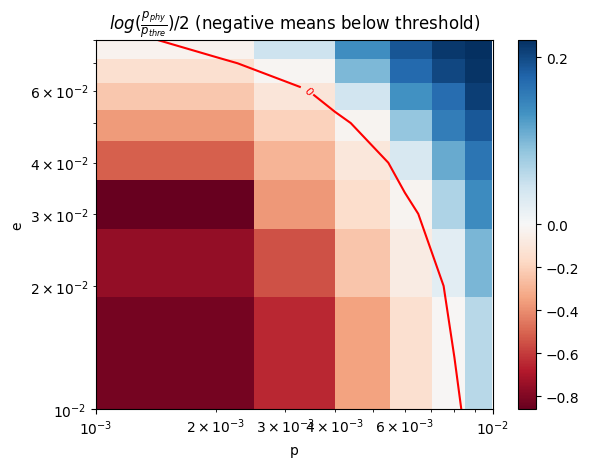

In [139]:
import matplotlib.colors as mcolors


plt.title(rf'$log(\frac{{p_{{phy}}}}{{p_{{thre}}}})/2$ (negative means below threshold)')
plt.xlabel('p')
plt.ylabel('e')
plt.imshow(slope_array, cmap= 'RdBu', norm= mcolors.TwoSlopeNorm(vmin = np.min(slope_array),vcenter = 0,vmax = np.max(slope_array)),
        extent=[ p_p_list[0], p_p_list[-1],  p_e_list[0], p_e_list[-1]], aspect='auto',origin='lower')
plt.colorbar()

X, Y = np.meshgrid(p_p_list, p_e_list)

# Plot the contour line at z = 0
contour = plt.contour(X, Y, slope_array, levels=[0], colors='red')

# Optionally add labels
plt.clabel(contour, inline=True, fontsize=8)

plt.xscale('log')
plt.yscale('log')


qbt_lifetime_array: ['1.00e-02', '2.00e-02', '3.98e-02', '7.94e-02', '1.58e-01', '3.16e-01', '6.31e-01', '1.26e+00', '2.51e+00', '5.01e+00', '1.00e+01']
p_p_array: [2.00000000e-02 1.00237447e-02 5.02377286e-03 2.51785082e-03
 1.26191469e-03 6.32455532e-04 3.16978638e-04 1.58865647e-04
 7.96214341e-05 3.99052463e-05 2.00000000e-05]
decay_lifetime_array: ['1.00e-02', '2.00e-02', '3.98e-02', '7.94e-02', '1.58e-01', '3.16e-01', '6.31e-01', '1.26e+00', '2.51e+00', '5.01e+00', '1.00e+01']
p_e_array: [2.00000000e-02 1.00237447e-02 5.02377286e-03 2.51785082e-03
 1.26191469e-03 6.32455532e-04 3.16978638e-04 1.58865647e-04
 7.96214341e-05 3.99052463e-05 2.00000000e-05]


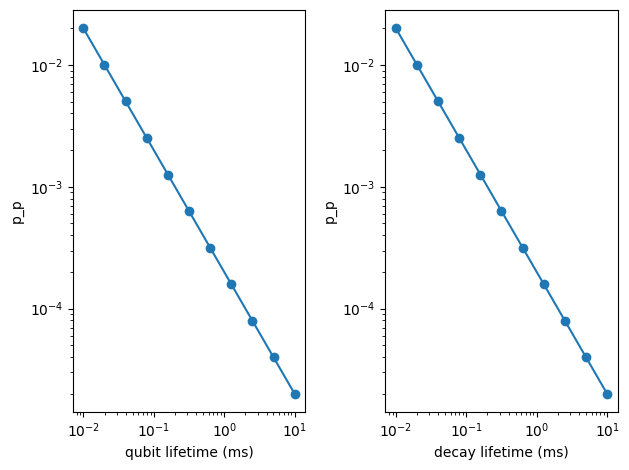

In [138]:
gate_time = 200 # ns
qbt_lifetime_array = 10 ** np.linspace(-2,1,11) * 1e6 # ms
formatted_floats = [f"{num:.2e}" for num in qbt_lifetime_array/1e6]
print(f"qbt_lifetime_array: {formatted_floats}")

p_p_array = gate_time / qbt_lifetime_array
print(f"p_p_array: {p_p_array}")

fig, axes = plt.subplots(1,2)
axes[0].plot(qbt_lifetime_array/1e6,p_p_array,marker = 'o')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('qubit lifetime (ms)')
axes[0].set_ylabel('p_p')


decay_lifetime_array = 10 ** np.linspace(-2,1,11) * 1e6 # ms
formatted_floats = [f"{num:.2e}" for num in decay_lifetime_array/1e6]
print(f"decay_lifetime_array: {formatted_floats}")

p_e_array = gate_time / decay_lifetime_array
print(f"p_e_array: {p_e_array}")

axes[1].plot(decay_lifetime_array/1e6,p_e_array,marker = 'o')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('decay lifetime (ms)')
axes[1].set_ylabel('p_p')


plt.tight_layout()